### Noise variance on W
Using the estimated noise variance on W:
- Compare the estimates across 2 sets of MDTB

In [1]:
import init_paths
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as at
import glob
import matplotlib.pyplot as plt
from cortico_cereb_connectivity.scripts.script_train_eval_models import *
import cortico_cereb_connectivity.evaluation as ev
import matplotlib.pyplot as plt
from scipy import stats
import SUITPy as suit

Matplotlib created a temporary cache directory at /tmp/matplotlib-u0zdfig1 because the default path (/localscratch/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1]):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale)

In [3]:
var_folder = os.path.join(os.getcwd(), '../data/variance')

dataset = fdata.get_dataset_class(gl.base_dir,
                                    dataset="MDTB")
subject_list = dataset.get_participants().participant_id

# read subject weight variance matrix from file
sigma2_ses_s1 = []
sigma2_ses_s2 = []
for s, sub in enumerate(subject_list):
    print(f'Reading {str(sub)} sigma2_eps...')
    file_path = os.path.join(var_folder, f'sigma2_eps_ses-s1_{str(sub)}.npy')
    sigma2_ses_s1.append(np.load(file_path))
    file_path = os.path.join(var_folder, f'sigma2_eps_ses-s2_{str(sub)}.npy')
    sigma2_ses_s2.append(np.load(file_path))
    
    # plt.hist(variance, bins='auto', alpha=0.5)
    # shape, loc, scale = stats.gamma.fit(variance[~np.isnan(variance)], floc=0)
    # params_list.append((shape, loc, scale))
    # print(f'max: {np.nanmax(variance)}')

# # show
# plt.title('Histogram of sigma2_eps')
# plt.xlim((0,0.1))
# plt.show()

Reading sub-02 sigma2_eps...
Reading sub-03 sigma2_eps...
Reading sub-04 sigma2_eps...
Reading sub-06 sigma2_eps...
Reading sub-08 sigma2_eps...
Reading sub-09 sigma2_eps...
Reading sub-10 sigma2_eps...
Reading sub-12 sigma2_eps...
Reading sub-14 sigma2_eps...
Reading sub-15 sigma2_eps...
Reading sub-17 sigma2_eps...
Reading sub-18 sigma2_eps...
Reading sub-19 sigma2_eps...
Reading sub-20 sigma2_eps...
Reading sub-21 sigma2_eps...
Reading sub-22 sigma2_eps...
Reading sub-24 sigma2_eps...
Reading sub-25 sigma2_eps...
Reading sub-26 sigma2_eps...
Reading sub-27 sigma2_eps...
Reading sub-28 sigma2_eps...
Reading sub-29 sigma2_eps...
Reading sub-30 sigma2_eps...
Reading sub-31 sigma2_eps...


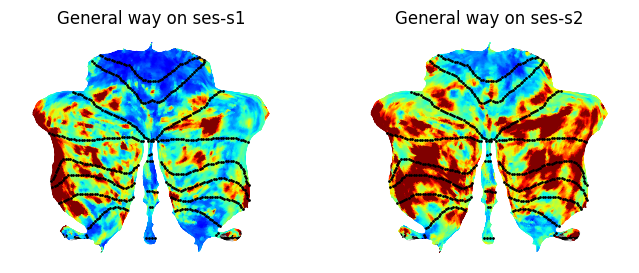

In [7]:
cereb_atlas,_ = at.get_atlas('SUIT3')
subj_i = [1]
for i in subj_i:
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plot_cereb_data(sigma2_ses_s1[i],cereb_atlas,cscale=[0,1])
    plt.title(f'General way on ses-s1')
    plt.subplot(1,2,2)
    plot_cereb_data(sigma2_ses_s2[i],cereb_atlas,cscale=[0,1])
    plt.title(f'General way on ses-s2')


In [4]:
R_list = []
RSME_list = []
for i in range(len(subject_list)):
    R, _ = ev.calculate_R(sigma2_ses_s1[i], sigma2_ses_s2[i])
    RSME_list.append(np.sqrt(np.nanmean((sigma2_ses_s1[i] - sigma2_ses_s2[i])**2)))
    R_list.append(R)
print(f'ses-s1 and ses-s2: Corr={np.nanmean(R_list):.2f}, RSME={np.nanmean(RSME_list):.1e}')

ses-s1 and ses-s2: Corr=0.78, RSME=7.3e-01


In [5]:
df2=rm.comb_eval(models=['MDs1-ind-scale','MDs1-loo-scale','MDs1-avg-scale'],eval_data=['MDTBs2'])
df2['model_type'] = df2['model']
df2.loc[df2['model'].isna() & (df2.subj_id != df2.eval_subj),'model_type']='diff'
df2.loc[df2['model'].isna() & (df2.subj_id == df2.eval_subj),'model_type']='same'
df_same = df2[df2['model_type']=='same']
df_same.reset_index(drop=True, inplace=True)
df_avg = df2[df2['model_type']=='avg']
df_avg.reset_index(drop=True, inplace=True)
df_loo = df2[df2['model_type']=='loo']
df_loo.reset_index(drop=True, inplace=True)

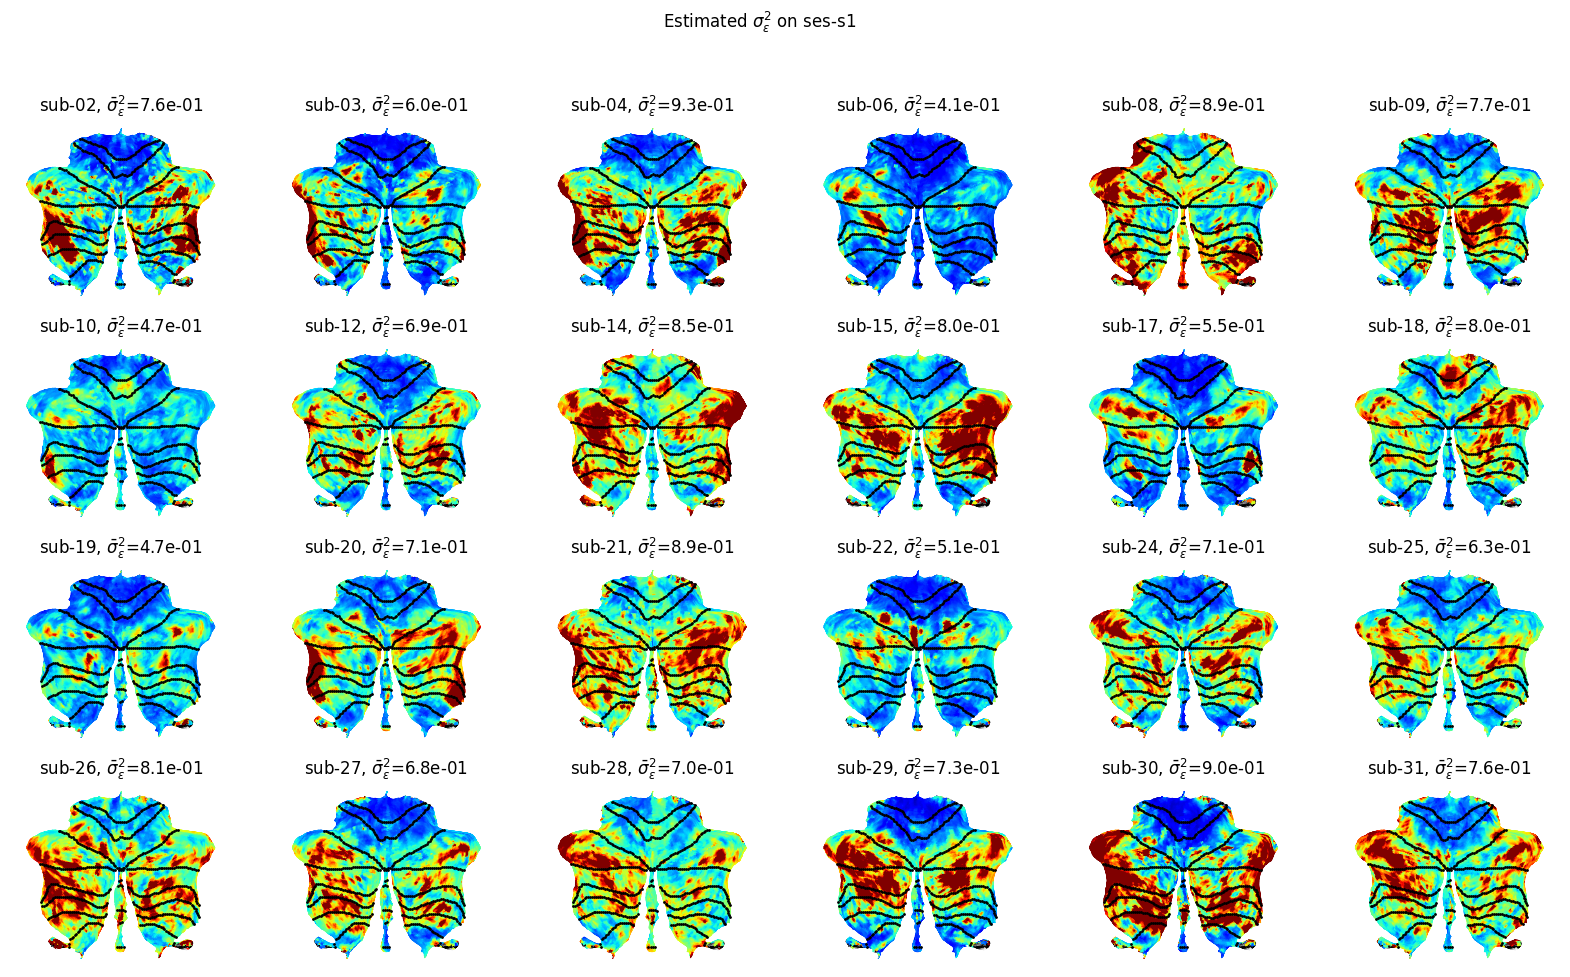

In [7]:
cereb_atlas,_ = at.get_atlas('SUIT3')
plt.figure(figsize=(20,11))
plt.suptitle('Estimated $\sigma^2_\epsilon$ on ses-s1')
for i, sub in enumerate(subject_list):
    plt.subplot(4,6,i+1)
    plot_cereb_data(sigma2_ses_s1[i],cereb_atlas,cscale=[0,1.2])
    plt.title(f'{sub}, $\\bar{{\\sigma}}^2_\\epsilon$={np.nanmean(sigma2_ses_s1[i]):.1e}')

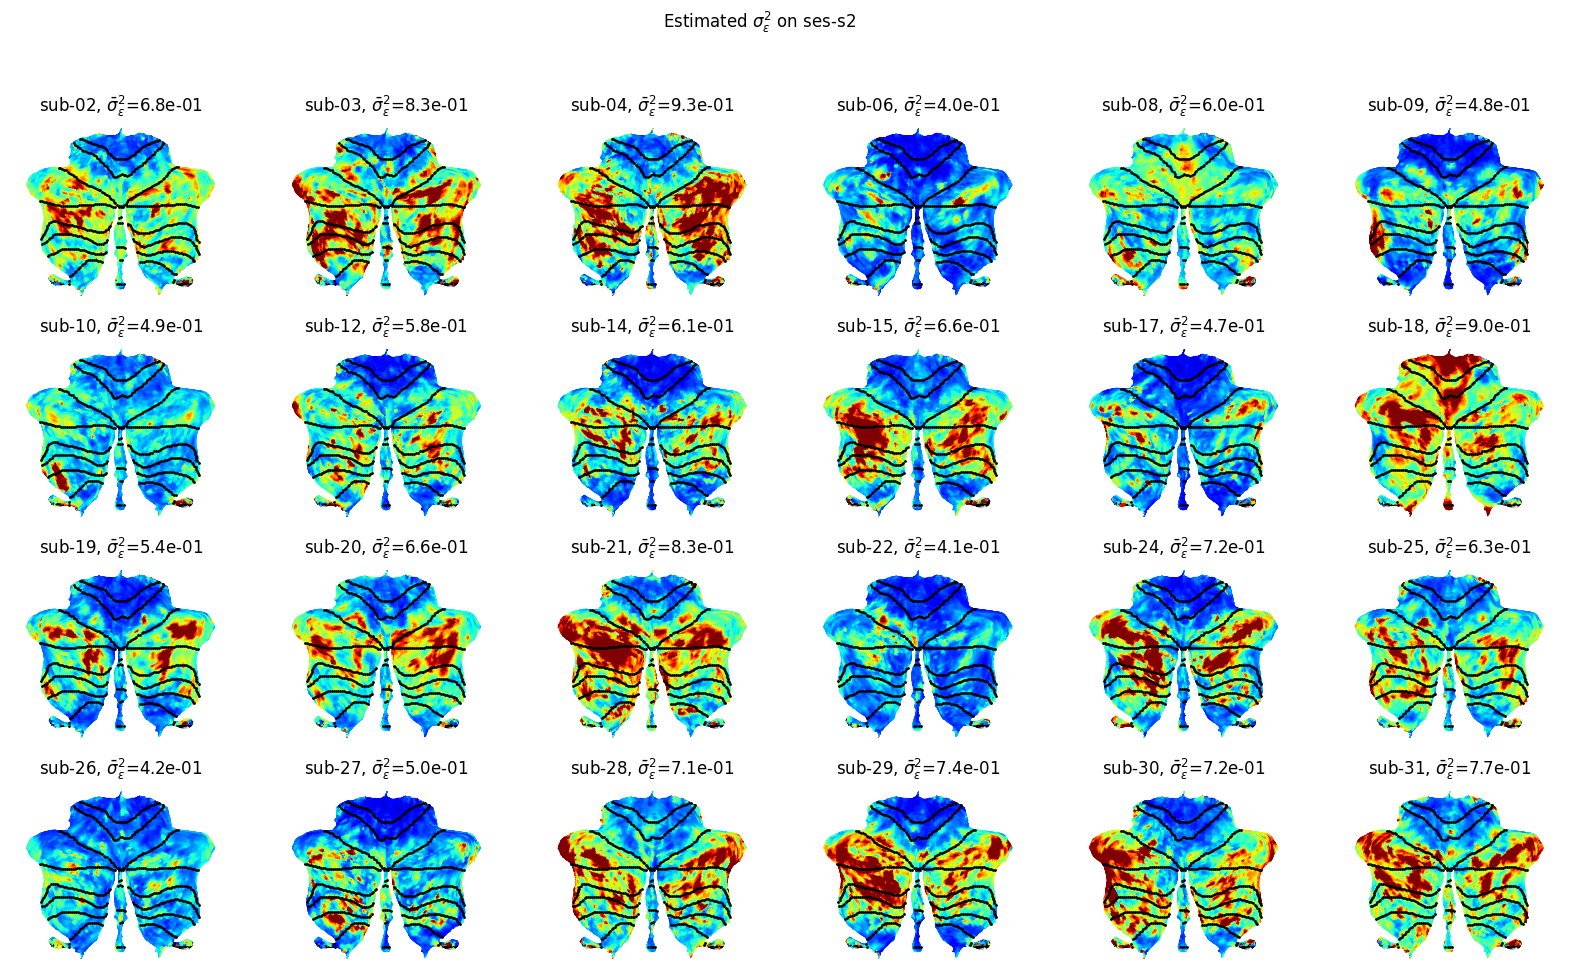

In [8]:
cereb_atlas,_ = at.get_atlas('SUIT3')
plt.figure(figsize=(20,11))
plt.suptitle('Estimated $\sigma^2_\epsilon$ on ses-s2')
for i, sub in enumerate(subject_list):
    plt.subplot(4,6,i+1)
    plot_cereb_data(sigma2_ses_s2[i],cereb_atlas,cscale=[0,1.2])
    plt.title(f'{sub}, $\\bar{{\\sigma}}^2_\\epsilon$={np.nanmean(sigma2_ses_s2[i]):.1e}')

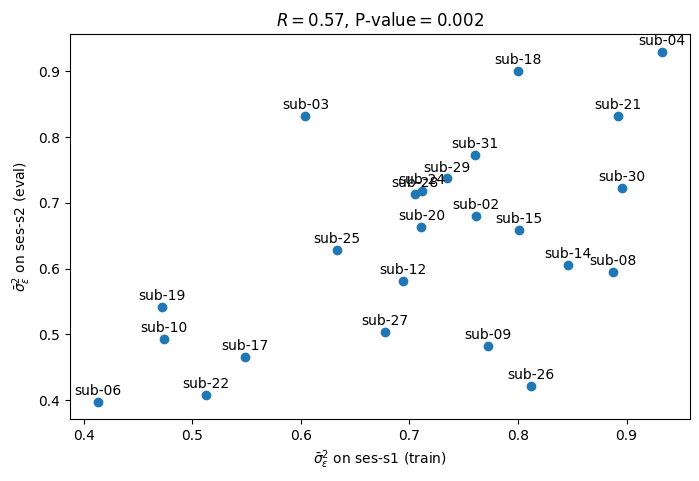

In [9]:
mean_sigma2_ses1 = np.nanmean(np.stack(sigma2_ses_s1, axis=0), axis=1)
mean_sigma2_ses2 = np.nanmean(np.stack(sigma2_ses_s2, axis=0), axis=1)
plt.figure(figsize=(8,5))
plt.scatter(mean_sigma2_ses1, mean_sigma2_ses2)
plt.xlabel('$\\bar{{\\sigma}}^2_\\epsilon$ on ses-s1 (train)')
plt.ylabel('$\\bar{{\\sigma}}^2_\\epsilon$ on ses-s2 (eval)')
R, Pval = stats.pearsonr(mean_sigma2_ses1, mean_sigma2_ses2, alternative='greater')
plt.title(f'$R={R:.2f}$, P-value$={Pval:.3f}$')
for i, sub in enumerate(subject_list):
    plt.annotate(f'{sub}', (mean_sigma2_ses1[i], mean_sigma2_ses2[i]), textcoords="offset points", xytext=(0,5), ha='center')

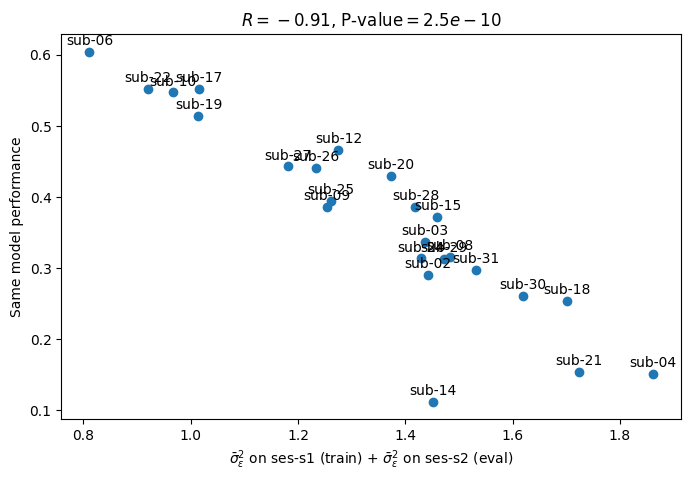

In [10]:
mean_sigma2 = np.nanmean(np.stack(sigma2_ses_s1, axis=0), axis=1) + np.nanmean(np.stack(sigma2_ses_s2, axis=0), axis=1)
plt.figure(figsize=(8,5))
plt.scatter(mean_sigma2, df_same['R_eval'])
plt.xlabel('$\\bar{{\\sigma}}^2_\\epsilon$ on ses-s1 (train) + $\\bar{{\\sigma}}^2_\\epsilon$ on ses-s2 (eval)')
plt.ylabel('Same model performance')
R, Pval = stats.pearsonr(mean_sigma2, df_same['R_eval'], alternative='less')
plt.title(f'$R={R:.2f}$, P-value$={Pval:.1e}$')
for i, sub in enumerate(subject_list):
    plt.annotate(f'{sub}', (mean_sigma2[i], df_same['R_eval'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')